In [5]:
import numpy as np
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
from datetime import datetime, timedelta
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from viz import  viz_interactive, viz_map_utils
import plotly
import re
import plotly.express as px
from urllib.request import urlopen
import json
import plotly.graph_objs as go


#Load data and add prediction
def add_pre(df, var, name, newname):
    h = df_county[var + '1-day'].copy()
    for i in range(2,8):
        h = np.vstack((h,df_county[var + str(i) +'-day']))
    df_county[name] = [h.T[i] for i in range(len(h.T))]



## Add prediction history to dataframe
def add_prediction_history(df_tab):
    def find_interval(a):
        return [max(a[6][0] - a[5][1], 0), max(a[6][1] - a[5][0], 0)]
    def add_predictions_7day(data,df):
        data = data.sort_values(by='countyFIPS')
        dic = {'cases':'Cases','deaths':'Deaths'}
        for i in range(df_tab.shape[0]):
            for key in dic.keys():
                df.loc[i,'pred_7day_'+key].append(data.loc[i,'Predicted '+ dic[key] +' 7-day'])
                df.loc[i,'pred_7day_'+key+'_interval'].append(data.loc[i,'Predicted '+dic[key]+' Intervals'][6])
                df.loc[i,'pred_7day_new_'+key].append(max(0, data.loc[i,'Predicted '+ dic[key] +' 7-day']-data.loc[i,'Predicted '+ dic[key] +' 6-day']))
                df.loc[i,'pred_7day_new_'+key+'_interval'].append(find_interval(data.loc[i,'Predicted '+ dic[key] +' Intervals']))

    cached_dir=oj(parentdir, 'data')
    i = 0
    for c in ['deaths','cases']:
        for pre in ['pred_7day_','pred_7day_new_']:
            df_tab[pre + c] =[[] for _ in range(df_tab.shape[0])]
            df_tab[pre + c + '_interval'] =[[] for _ in range(df_tab.shape[0])]
    date2 = []
    k = 0
    while True:
        d = (datetime.today() - timedelta(days=i)).date()
        i += 1
        if cached_dir is not None:
            cached_fname = oj(cached_dir, f'preds_{d.month}_{d.day}_cached.pkl')
            if os.path.exists(cached_fname):
                date2.append(d + timedelta(days = 6))
                add_predictions_7day(pd.read_pickle(cached_fname),df_tab)
            else:
                k += 1
                if k > 1:
                    break
    return df_tab, date2
# generate html for individual counties
def generate_all_counties():
    print('generating html for counties')
    df_tab = df_county[['CountyName', 'State', 'new_cases','new_deaths',
             'deaths', 'cases','countyFIPS','pred_cases','pred_deaths','Predicted Deaths Intervals','Predicted Cases Intervals',
             'pred_new_cases','pred_new_deaths','pred_new_cases_interval','pred_new_deaths_interval']]
    df_tab = df_tab.rename(columns={'CountyName': 'County', 'State': 'State',
                                'Predicted Deaths Intervals': 'pred_deaths_interval',
                                'Predicted Cases Intervals': 'pred_cases_interval'})
    dates = viz_map_utils.date_in_data(df_county)
    df_tab, date2 = add_prediction_history(df_tab)
    viz_interactive.viz_curves_all_counties(df_tab, oj(parentdir, 'results/All_counties/'), dates,date2)
    print('succesfully generated all county html')

## Rename columns
def rename(df):
    return df.rename(columns={"tot_deaths": "Cumulative Deaths", "tot_cases": "Cumulative Cases",
                      "new_cases_last": "New Cases", "new_deaths_last": "New Deaths",
                              'CountyName':'County','tot_deaths_rate':'Deaths per 100k',
                      'tot_cases_rate':'Cases per 100k','new_cases_last_rate': 'New Cases per 100k',
                      'new_deaths_last_rate': 'New Deaths per 100k'})
# Generate map and table html code 
def generate_map(df):
    df = rename(df)
    df['POS'] = df['County'] + ', '+ df['StateName']
    maps = []
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)
    for key in keys:
        fig = px.choropleth(df, geojson=counties, locations='countyFIPS', color=np.log(df[key]+1),
                            color_continuous_scale =['#F7E8E4','#F5C8BB','#B96D67','#A83C3B',
                                '#8B2222','#5B0D0D','#5A2318'],
                           scope="usa",
                           hover_data = ['State','County','Cumulative Cases','New Cases','Cumulative Deaths'
                                         ,'New Deaths','Deaths per 100k','Cases per 100k','New Cases per 100k',
                                         'New Deaths per 100k'],
                   title = key + ' on ' + (datetime.today()-timedelta(days=1)).strftime('%m-%d'))
        fig.update_layout(coloraxis_colorbar=dict(len=0.75,
                                  title=key, 
                                  tickvals = [2.302585092994046,4.605170185988092,6.907755278982137,9.210340371976184,11.512925464970229],
                                  ticktext = ['10', '100', '1k', '10k', '100k','1000k'],
                                  x=1, y= 0.5))
        ## update the hover information
        for c in ["countyFIPS=%{location}<br>","<br>color=%{z}"]:
            fig['data'][0]['hovertemplate'] =fig['data'][0]['hovertemplate'].replace(c,"")
        fig['data'][0]['hovertemplate'] =fig['data'][0]['hovertemplate'].replace("=",": ")
        fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
        fig.update_layout(
            paper_bgcolor='rgb(0,0,0)',
            plot_bgcolor='rgb(0,0,0)',
            template='plotly_dark',
        )
        fig['layout'].update(width=900, height=450, autosize=True,title_x=0.3)
        if key == 'Cumulative Cases':
            fig.write_image(oj(parentdir,"results/search_map.png"),width=900, height=450)
        maps.append(plotly.offline.plot(fig,include_plotlyjs=False,output_type='div'))
    
        df_tab = df.sort_values(by = key, ascending = False)
        df_tab = df_tab.reset_index(drop=True)[['POS',key]].loc[:19,:]
        fig = go.Figure(data=[go.Table(
            header=dict(values=['','County', key],
                line_color='grey',
                fill_color='darkgrey',
                font_color = 'white',
                font_size = 12,
                align='center'),
            cells=dict(values=[[i+1 for i in range(len(df_tab))],
                       df_tab['POS'], 
                       df_tab[key]], 
               line_color='darkgrey',
               fill_color='grey',
               font_color='white',
               font_size = 11,
               align='center'),
            columnwidth = [20,120,80])
            ])
        fig['layout'].update(paper_bgcolor='rgb(0,0,0)',
            plot_bgcolor='rgb(0,0,0)',margin=dict(l=0, r=0, t=0, b=0),width=200, height=550, autosize=True,template='plotly_dark')
        fig.write_image(oj(parentdir,"results/" + key + ".png"),width=200, height=550)

    print('succesfully generated search map')   
    return maps

# Fill the state full name according to their abbreviations#
def fillstate(df):
    us_state_abbrev = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
    }
    for i in range(df.shape[0]):
        if df.loc[i, "State"] not in us_state_abbrev.values():
            df.loc[i, "State"] = us_state_abbrev[df.loc[i,"StateName"]]

## update search.html
def update_html(maps):
    f = open(oj(parentdir,'results/template.html'),"r")
    content = f.read()
    for i, key in enumerate(keys):
        content = content.replace(key+' map', maps[i])
        id =re.search('<div id="([^ ]*)"',maps[i])
        content = content.replace(key + " id to replace",id.group(1))
    f = open(oj(parentdir,'results/search.html'),"w+")
    f.write(content)
    print('succesfully updated search html')

## Add cases/deaths rate to dataframe
def add_rates(df_county):
    for key in ['tot_deaths', 'tot_cases', 'new_deaths_last', 'new_cases_last']:
        df_county[key+'_rate'] = round(df_county[key] / df_county['PopulationEstimate2018']*100000,2)
## Add new cases/deaths to dataframe
def add_new(df_county):
    def get_col_name(key,days):
        return '#'+key + '_' +(datetime.today()-timedelta(days=days)).strftime('%m-%d-%Y')
    for key in ['Cases','Deaths']:
        df_county['new_'+key.lower()+'_last'] =  df_county[get_col_name(key,1)] - df_county[get_col_name(key,2)]
    for key in ['deaths','cases']:
        df_county['new_' + key] = [[] for _ in range(df_county.shape[0])]
        for i in range(df_county.shape[0]):
            df_county.loc[i,'new_'+key].append(df_county.loc[i, key][0])
            for j in range(1, len(df_county.loc[i, key])):
                df_county.loc[i, 'new_'+key]. append(df_county.loc[i, key][j] - df_county.loc[i, key][j-1])
def add_new_pre(df_county, var, name, newname):    
    h = df_county[var + '1-day'] - df_county[name]
    for i in range(2,8):
        h = np.vstack((h,df_county[var + str(i) + '-day'] - df_county[var + str(i - 1) + '-day']))
    df_county[newname] = [h.T[i] for i in range(len(h.T))]
    df_county[newname+'_interval'] = [[] for _ in range(df_county.shape[0])]

    def find_intervals(b, a):
        tmp = [[a[0][0] - b, a[0][1] - b]]
        for i in range(1, len(a)):
            tmp.append([max(a[i][0] - a[i - 1][1], 0), max(a[i][1] - a[i - 1][0], 0)])
        return tmp
    for i in range(df_county.shape[0]):
        df_county.loc[i,newname+'_interval'].extend(find_intervals(df_county.loc[i,name],df_county.loc[i,var+'Intervals'])) 
    return df_county  
    
if __name__ == '__main__':
    print('loading data...')
    NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
    df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data')).fillna(0)
    df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir=oj(parentdir, 'data')) # adds keys like "Predicted Deaths 1-day"

    ## orgnize predicts as array
    
    add_pre(df_county,'Predicted Cases ','pred_cases','pred_new_cases')
    add_pre(df_county,'Predicted Deaths ','pred_deaths','pred_new_deaths')

    ## add new cases/death to dataframe
    add_new(df_county)
    ## Add new cases/deaths predictions and their intervals 
    df_county = add_new_pre(df_county, 'Predicted Cases ', 'tot_cases', 'pred_new_cases')
    df_county = add_new_pre(df_county, 'Predicted Deaths ', 'tot_deaths', 'pred_new_deaths')

    ##fill missing values of some state full names
    fillstate(df_county)
    ## Add cases/deaths rate to the dataframe
    add_rates(df_county)
    #generate_all_counties()
    ## keys for the tab and map
    keys = ['Cumulative Cases','Cumulative Deaths','New Cases','New Deaths','Cases per 100k','Deaths per 100k','New Cases per 100k','New Deaths per 100k']
    ## generate maps in different tabs
    maps = generate_map(df_county)
    ## update html of search.html
    update_html(maps)


loading data...
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully
Cumulative Cases
Cumulative Deaths
New Cases
New Deaths
Cases per 100k
Deaths per 100k
New Cases per 100k
New Deaths per 100k
succesfully generated search map
succesfully updated search html


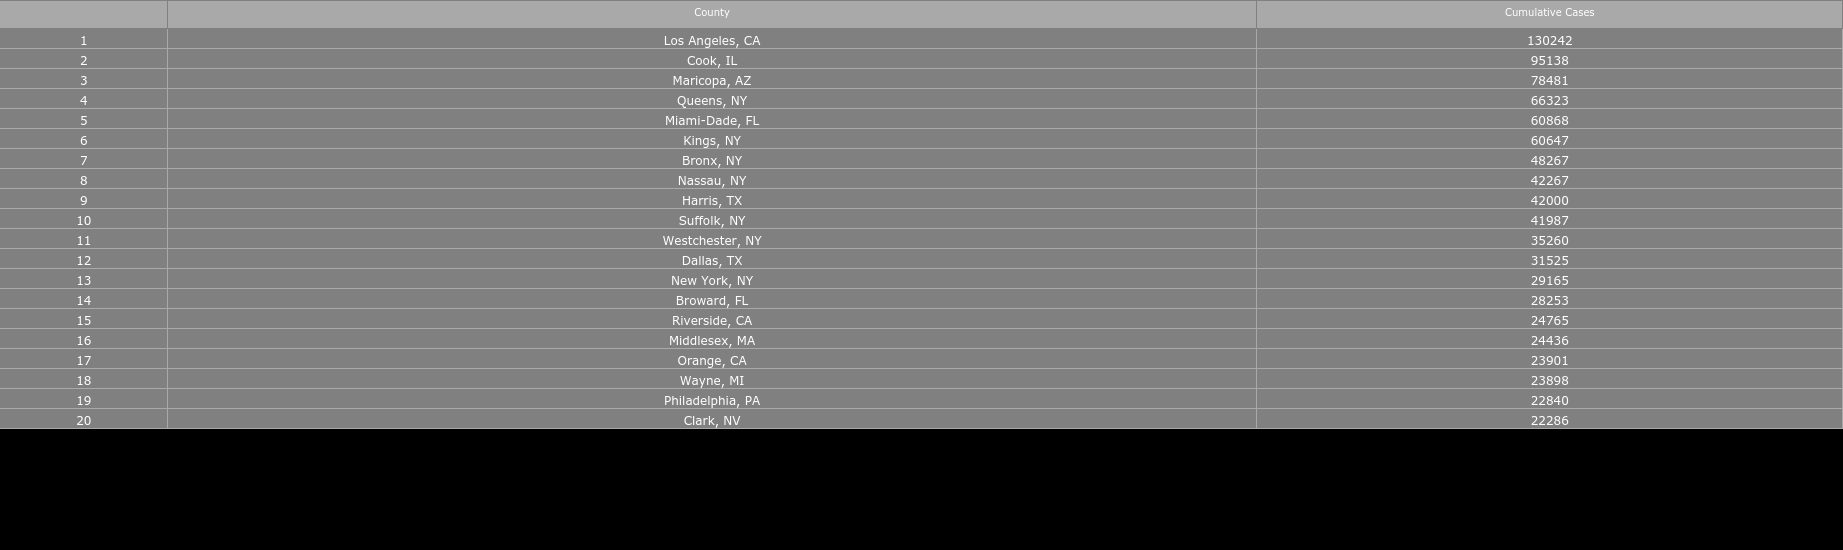

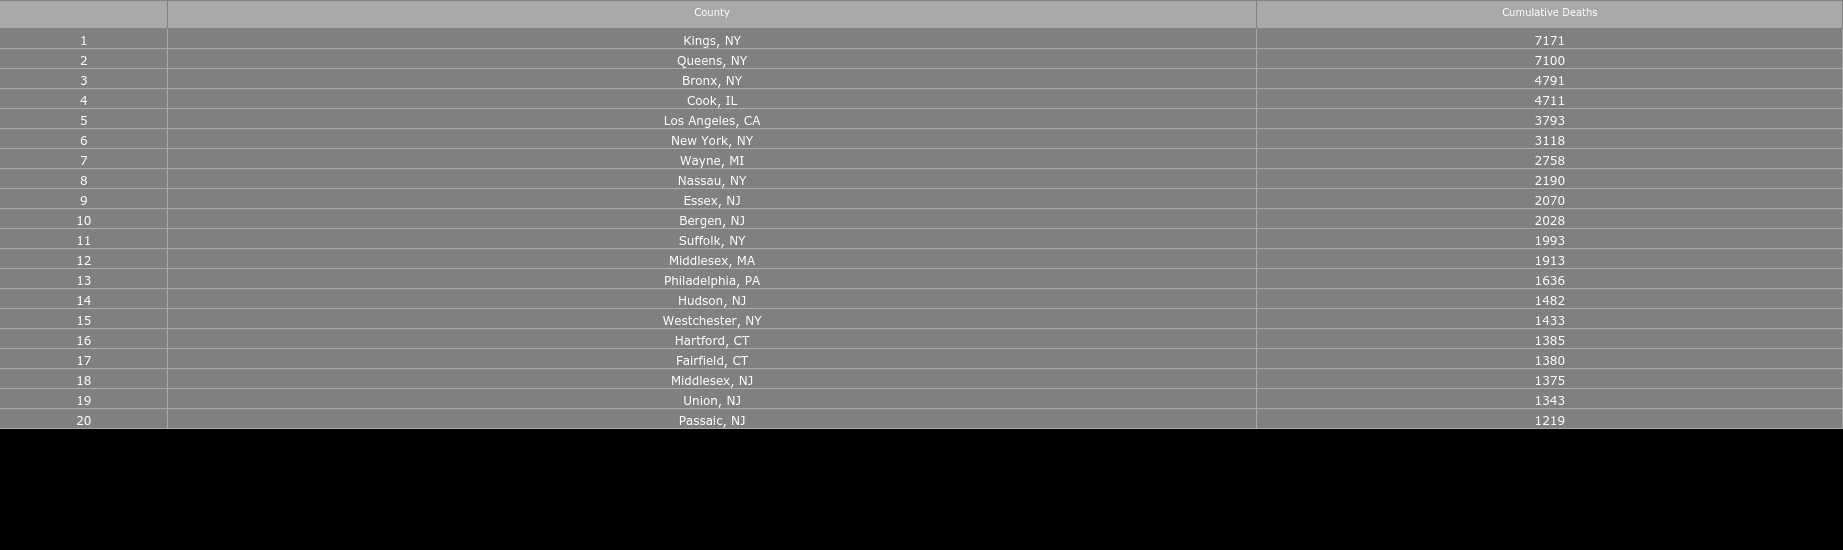

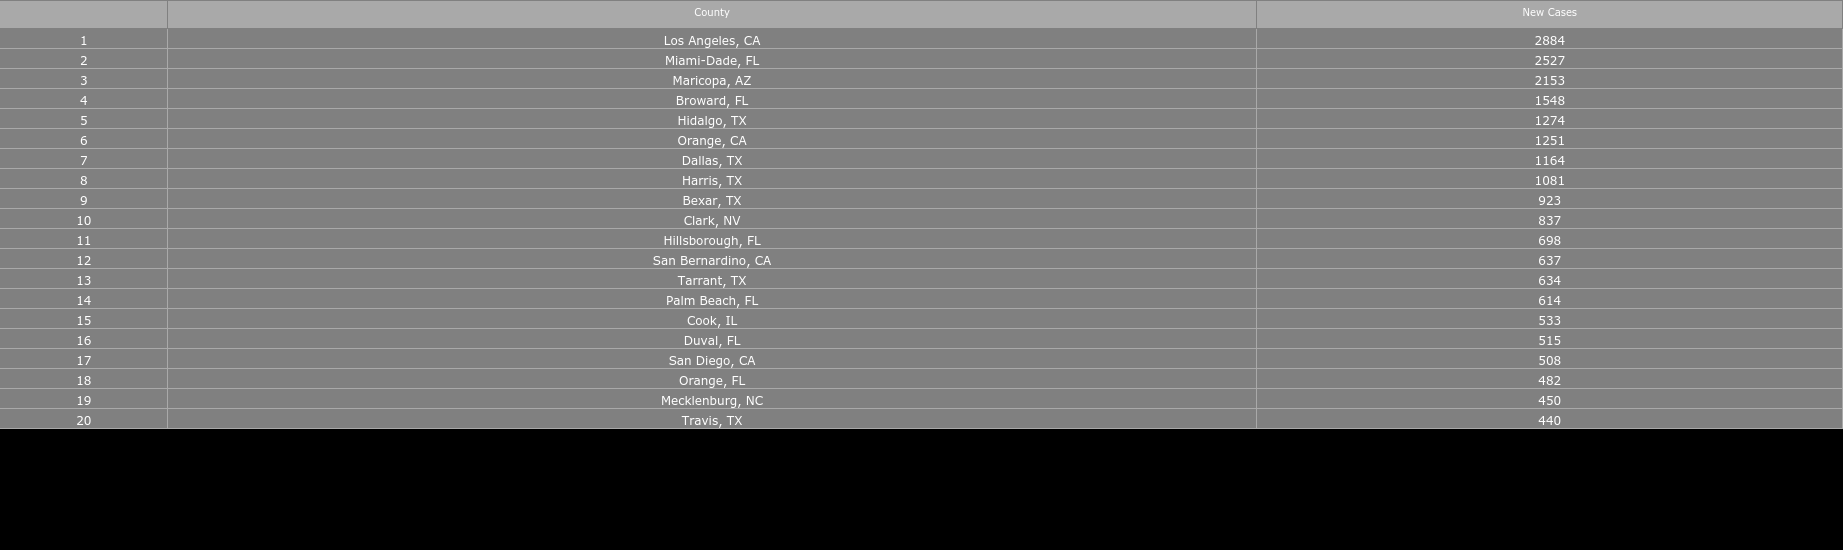

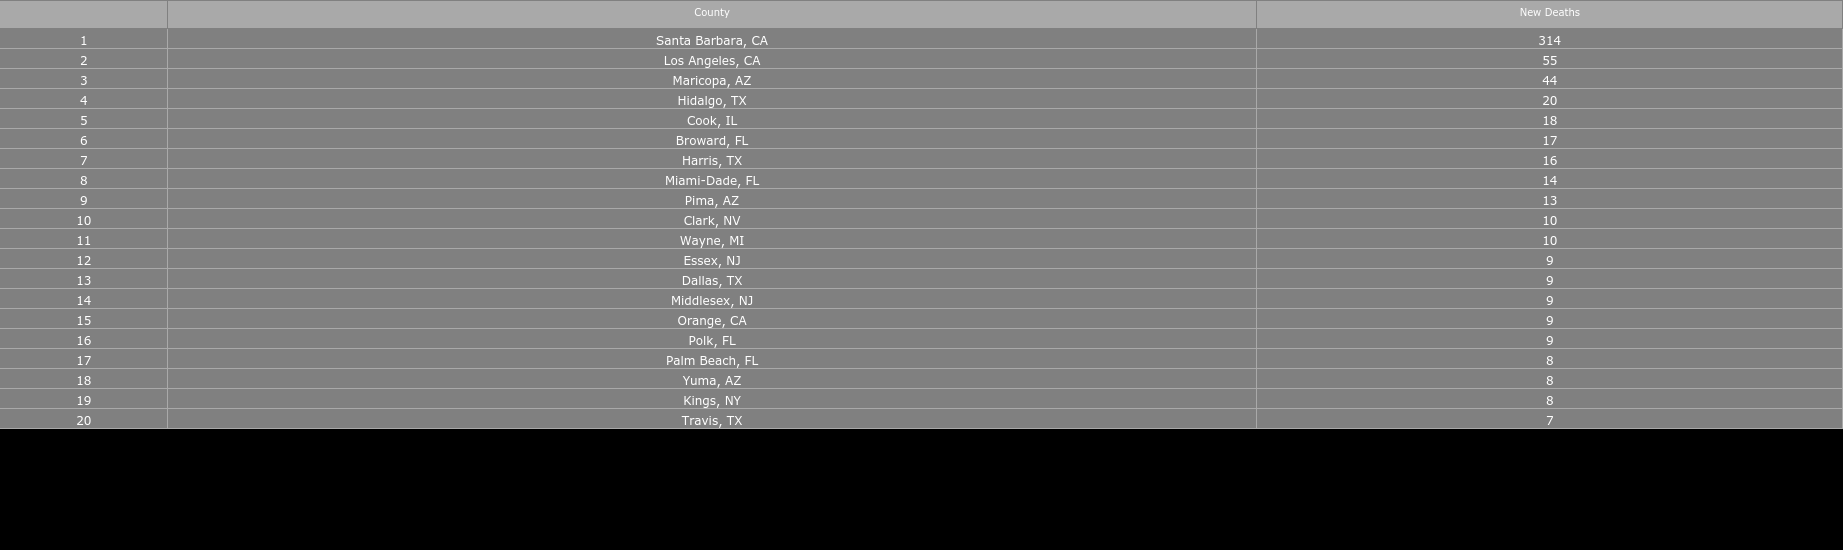

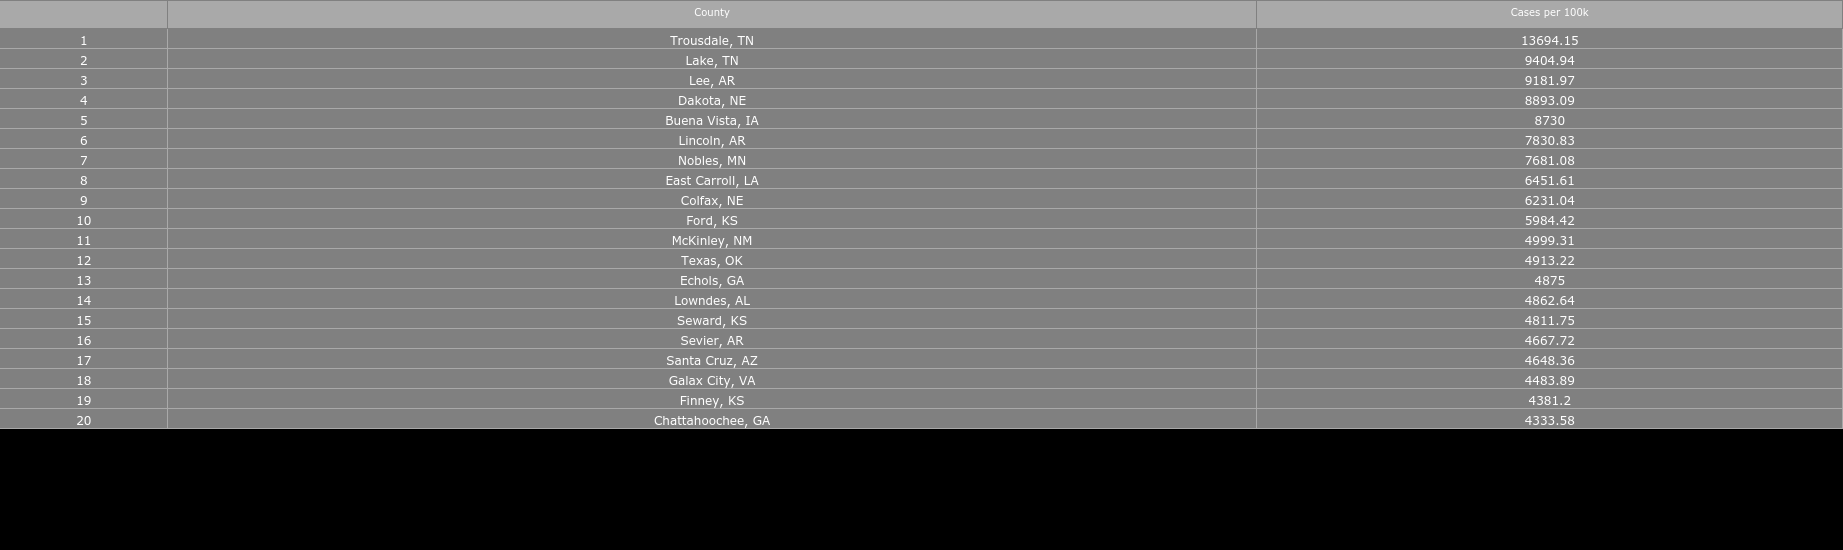

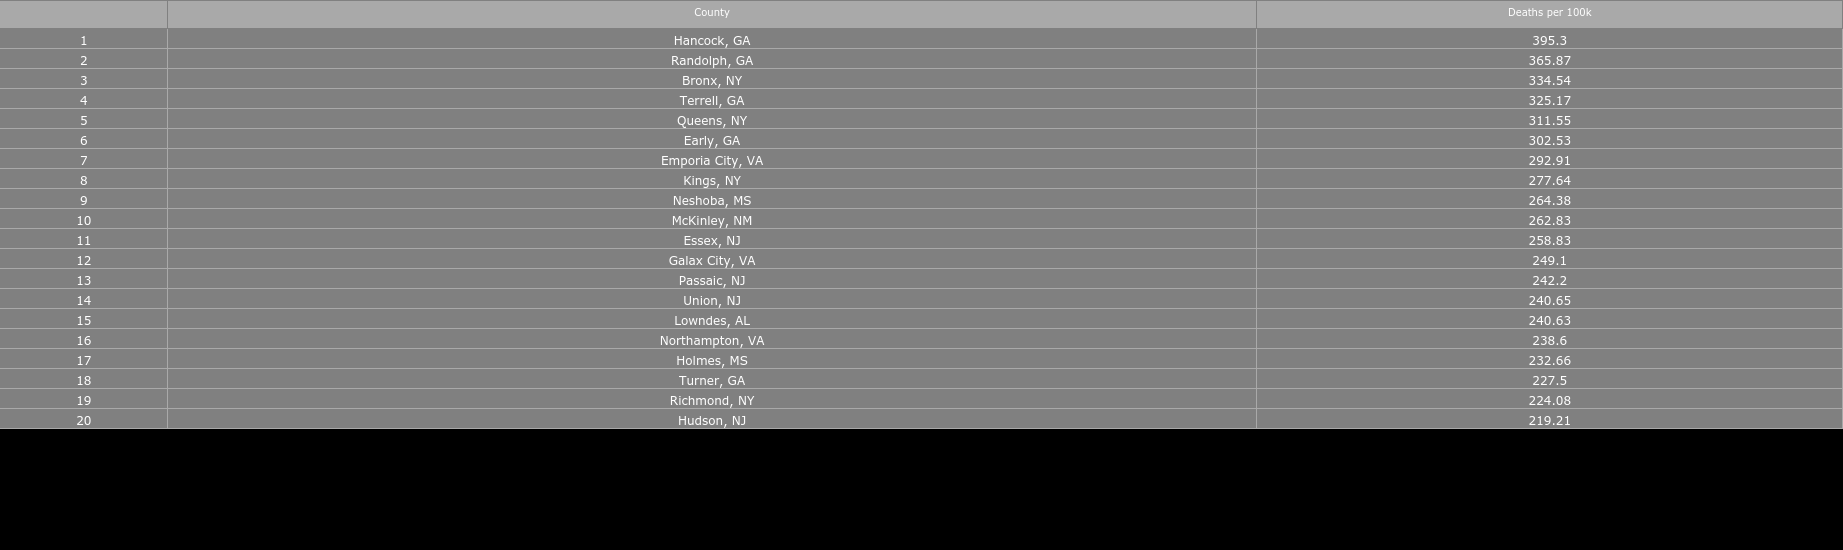

succesfully generated search map


In [24]:
if __name__ == '__main__':
    print('loading data...')
    NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
    df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data')).fillna(0)
    df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir=oj(parentdir, 'data')) # adds keys like "Predicted Deaths 1-day"

    ## orgnize predicts as array
    
    add_pre(df_county,'Predicted Cases ','pred_cases','pred_new_cases')
    add_pre(df_county,'Predicted Deaths ','pred_deaths','pred_new_deaths')

    ## add new cases/death to dataframe
    add_new(df_county)
    ## Add new cases/deaths predictions and their intervals 
    df_county = add_new_pre(df_county, 'Predicted Cases ', 'tot_cases', 'pred_new_cases')
    df_county = add_new_pre(df_county, 'Predicted Deaths ', 'tot_deaths', 'pred_new_deaths')

    ##fill missing values of some state full names
    fillstate(df_county)
    ## Add cases/deaths rate to the dataframe
    add_rates(df_county)
    #generate_all_counties()
    ## keys for the tab and map
    keys = ['Cumulative Cases','Cumulative Deaths','New Cases','New Deaths','Cases per 100k','Deaths per 100k','New Cases per 100k','New Deaths per 100k']
    ## generate maps in different tabs
    maps = generate_map(df_county)
    ## update html of search.html
    update_html(maps)

In [26]:
df_county

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,new_cases_last,new_deaths_last,new_deaths,new_cases,pred_new_cases,pred_new_cases_interval,pred_new_deaths,pred_new_deaths_interval,tot_deaths_rate,tot_cases_rate
1843,36047,36.0,47.0,Kings,NY,New York,40.640578,-73.954654,40.650523,-73.954811,...,87,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[163.50304460835468, 90.06899224317749, 23.302...","[[0, 106.35890741997719], [0, 122.630242698323...","[12.199524519990518, 12.149082497426207, 12.42...","[[5.252935761360277, 18.613744416325062], [0, ...",277.64,2348.08
1860,36081,36.0,81.0,Queens,NY,New York,40.683532,-73.814712,40.721294,-73.833451,...,82,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[175.68048915429972, 126.11845038553292, 83.91...","[[0, 150.46831412061874], [0, 213.465172139258...","[9.001256971961084, 8.147742177336113, 8.39049...","[[0, 30.460263838647734], [0, 138.419580192657...",311.55,2910.30
1822,36005,36.0,5.0,Bronx,NY,New York,40.856182,-73.864945,40.849354,-73.882363,...,59,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[123.40587964565202, 103.2277990085131, 82.006...","[[17.24813799644471, 111.29623560893378], [0, ...","[8.92742624114453, 9.536422385976948, 9.865483...","[[0, 20.105421146015942], [0, 42.9550766016645...",334.54,3370.29
602,17031,17.0,31.0,Cook,IL,Illinois,41.842959,-87.821180,41.865937,-87.757714,...,533,18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[554.5033383888513, 552.6035513773531, 552.603...","[[300.8721870547015, 808.1333273793716], [0, 1...","[19.78897501128631, 21.25428829634984, 21.4480...","[[6.491111448254742, 31.457079377549235], [0, ...",90.94,1836.47
199,06037,6.0,37.0,Los Angeles,CA,California,34.369957,-118.212742,34.065193,-118.244222,...,2884,55,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2177.0709089486627, 2433.4801245062263, 2433....","[[0, 8251.350996603753], [0, 20732.70010163320...","[60.050036913900385, 62.74261250124209, 63.469...","[[16.88680438335632, 98.71687636235401], [0, 2...",37.53,1288.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,17127,17.0,127.0,Massac,IL,Illinois,37.231522,-88.715590,37.178592,-88.714109,...,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6034335630526719, 0.7962451851913173, 0.811...","[[0, 1.0814240903138028], [0, 3.29713429365417...","[0.14669308880140852, 0.1522103324937143, 0.16...","[[0.0, 0.29227332931855127], [0, 0.59639858870...",0.00,113.64
1925,37087,37.0,87.0,Haywood,NC,North Carolina,35.560599,-82.984154,35.517983,-82.939915,...,6,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.0573078834992486, 3.351050572146761, 3.2854...","[[0, 6.632598049514428], [0, 13.92349067539942...","[0.15266510280603018, 0.1437327696221048, 0.13...","[[0.0, 0.30092337519790724], [0, 0.58432329304...",0.00,198.48
651,17129,17.0,129.0,Menard,IL,Illinois,40.027110,-89.798535,39.997260,-89.799507,...,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.434001274958959, 1.0844933777663073, 1.0571...","[[0, 4.375962650694198], [0, 7.363410924264642...","[0.15085813991821, 0.144266259356632, 0.140947...","[[0.0, 0.3008595703633423], [0, 0.590049099999...",0.00,252.28
652,17131,17.0,131.0,Mercer,IL,Illinois,41.202711,-90.735226,41.214043,-90.687167,...,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.2337370424936012, 1.057992268160568, 1.1403...","[[0, 3.636610426837997], [0, 4.57095767070377]...","[0.149307449

In [3]:
df = rename(df_county)

In [4]:
df

,countyFIPS,STATEFP,COUNTYFP,County,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,new_deaths,new_cases,pred_new_cases,pred_new_cases_interval,pred_new_deaths,pred_new_deaths_interval,Deaths per 100k,Cases per 100k,Deaths per 100k,New Cases per 100k
1843,36047,36.0,47.0,Kings,NY,New York,40.640578,-73.954654,40.650523,-73.954811,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[133.32847767974454, 70.53448174104415, 1.6643...","[[0, 69.80785531402944], [0, 261.7621636322074...","[9.586974978205944, 9.33893003869889, 9.596430...","[[0, 21.50908691710265], [0, 38.40986133657043...",278.14,2358.03,0.08,3.45
1860,36081,36.0,81.0,Queens,NY,New York,40.683532,-73.814712,40.721294,-73.833451,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[147.30839921269217, 107.56800459025544, 65.31...","[[0, 112.86287939241447], [0, 205.695041630227...","[9.008791552417279, 9.243452842242732, 9.48625...","[[0, 17.554521864778508], [0, 34.4595590060944...",312.04,2920.00,0.13,3.42
1822,36005,36.0,5.0,Bronx,NY,New York,40.856182,-73.864945,40.849354,-73.882363,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[113.96929872575856, 93.7137234476977, 72.6393...","[[0, 121.58412638807204], [0, 238.680935626391...","[10.98442440514009, 11.42541689128575, 11.7702...","[[2.532566131311796, 18.06548149752689], [0, 3...",335.23,3381.88,0.21,3.91
602,17031,17.0,31.0,Cook,IL,Illinois,41.842959,-87.821180,41.865937,-87.757714,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[373.0030138391885, 347.10318183666095, 347.10...","[[124.85852437105495, 621.1464981264144], [0, ...","[13.983984808883179, 14.553940643217175, 14.73...","[[0, 31.686080112711352], [0, 55.5036432130518...",91.52,1856.70,0.23,5.83
199,06037,6.0,37.0,Los Angeles,CA,California,34.369957,-118.212742,34.065193,-118.244222,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2943.500350196846, 3277.5003945264034, 3277.5...","[[1721.1475158835237, 4165.853214392409], [0, ...","[24.02693858275188, 40.50433717306487, 40.8754...","[[0, 71.15301801187934], [0, 155.9644386438653...",38.53,1388.42,0.71,41.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,37115,37.0,115.0,Madison,NC,North Carolina,35.860713,-82.710672,35.839078,-82.638666,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.7063404470730461, 0.6787012083652613, 0.665...","[[0, 2.6859457713289068], [0, 2.96355796404027...","[0.14880148987432038, 0.14862303059045082, 0.1...","[[0.0, 0.29663707315167837], [0, 0.59451588807...",0.00,82.71,0.00,0.00
656,17139,17.0,139.0,Moultrie,IL,Illinois,39.638360,-88.624049,39.631979,-88.614419,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.18206536662749073, 0.25033380207094424, 0.1...","[[0, 5.005650113920964], [0, 6.951794408376237...","[0.15102123417492047, 0.14399360390321936, 0.1...","[[0.0, 0.3009607222125955], [0, 0.589884777517...",0.00,169.87,0.00,6.79
1929,37095,37.0,95.0,Hyde,NC,North Carolina,35.535316,-76.245711,35.434210,-76.208134,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8248092840980235, 0.8053791560241734, 0.741...","[[0, 3.134904653325897], [0, 5.929559544470187...","[0.14800638272851638, 0.14884807218621635, 0.1...","[[0.0, 0.29590867019126393], [0, 0.59503799895...",0.00,592.73,0.00,0.00
660,17147,17.0,147.0,Piatt,IL,Illinois,40.008339,-88.595565,40.007008,-88.581585,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.34360653181368406, 0.3242069158506453, 0.29...","[[0, 0.8115870094301947]